In [26]:
from Bio import Phylo
from io import StringIO

In [2]:
def dict_min(D):
    m, i, j = None, None, None
    for a, b in D:
        if m is None or D[(a,b)] < m:
            m, i, j = D[(a,b)], a, b
    return i, j

In [3]:
def dict_flat(D):
    res = dict()
    for a in D:
        for b in D[a]:
            res[(a,b)] = D[a][b]
    return res

In [4]:
def nested_len(X):
    if type(X) is tuple:
        res = 0
        for x in X:
            res += nested_len(x)
    else:
        res = 1
    return res

In [66]:
def newick(structure):
    lastkey = list(structure.keys())[-1]
    
    def helper(node, parent_len):
        a, b = node
        if type(a) is tuple:
            l = helper(a, structure[node])
        else:
            l = f'{a}:{structure[node]:.2f}'
        if type(b) is tuple:
            r = helper(b, structure[node])
        else:
            r = f'{b}:{structure[node]:.2f}'
        return f'({l},{r}):{parent_len-structure[node]:.2f}'
        
    res = helper(lastkey, structure[lastkey])
    return res.replace(':0.00', ';')

In [74]:
def WPGMA(dist):
    res = dict()
    M = dict_flat(dist)
    
    while len(M) > 0:
        i, j = dict_min(M)
        newM = dict()
        for a, b in M:
            if a in (i, j) and b in (i, j):
                res[(i,j)] = M[(i,j)]/2
            elif a in (i, j):
                newM[((i,j), b)] = (M[(i,b) if (i,b) in M else (b,i)] + M[(j,b) if (j,b) in M else (b,j)])/2
            elif b in (i, j):
                newM[(a, (i,j))] = (M[(a,i) if (a,i) in M else (i,a)] + M[(a,j) if (a,j) in M else (j,a)])/2
            else:
                newM[(a,b)] = M[(a,b)]
        M = newM   
        
    return newick(res)

In [75]:
def UPGMA(dist):
    res = dict()
    M = dict_flat(dist)
    
    while len(M) > 0:
        i, j = dict_min(M)
        i_len = nested_len(i)
        j_len = nested_len(j)
        newM = dict()
        for a, b in M:
            if a in (i, j) and b in (i, j):
                res[(i,j)] = M[(i,j)]/2
            elif a in (i, j):
                newM[((i,j), b)] = (i_len*M[(i,b) if (i,b) in M else (b,i)] + j_len*M[(j,b) if (j,b) in M else (b,j)])/(i_len+j_len)
            elif b in (i, j):
                newM[(a, (i,j))] = (i_len*M[(a,i) if (a,i) in M else (i,a)] + j_len*M[(a,j) if (a,j) in M else (j,a)])/(i_len+j_len)
            else:
                newM[(a,b)] = M[(a,b)]
        M = newM
    
    return newick(res)

In [81]:
def NJ(dist):
    n = len(dist)+1
    M = dict_flat(dist)
    
    res = dict()
    
    while n > 2:   
        Q = dict()

        for a, b in M:
            q = (n-3)*M[(a,b)]
            for i,j in M:
                if (a in (i,j) or b in (i,j)):
                    q -= M[(i,j)]
            Q[(a,b)] = q

        a, b = dict_min(Q)

        da = 0
        for i, j in M:
            if a in (i,j):
                da += M[(i, j)]
            if b in (i,j):
                da -= M[(i, j)]
        da /= 2*(n-2)
        da += M[(a, b)]/2
        db = M[(a, b)] - da

        res[(a,b)] = (da, db)

        newM = dict()
        for i, j in M:
            if (i,j) != (a,b):
                if i in (a,b):
                    newM[(j, (a,b))] = (M[(a,j) if (a,j) in M else (j,a)] + M[(b,j) if (b,j) in M else (j,b)] - M[(a,b)])/2
                elif j in (a,b):
                    newM[(i, (a,b))] = (M[(a,i) if (a,i) in M else (i,a)] + M[(b,i) if (b,i) in M else (i,b)] - M[(a,b)])/2
                else:
                    newM[(i,j)] = M[(i,j)]
        n -= 1
        M = newM

    lastkey = list(M.keys())[0]
    res[lastkey] = (M[lastkey], M[lastkey])
    
    def helper(node):
        a, b = node
        a_len, b_len = res[node]
        if type(a) is tuple:
            l = helper(a) + f':{a_len:.2f}'
        else:
            l = f'{a}:{a_len:.2f}'
        if type(b) is tuple:
            r = helper(b) + f':{b_len:.2f}'
        else:
            r = f'{b}:{b_len:.2f}'
        return f'({l},{r})'
    
    return helper(lastkey) + ';'

In [9]:
test1 = {'A': {'B': 16, 'C': 16, 'D': 10}, 
         'B': {'C': 8, 'D': 8}, 
         'C': {'D': 4}}
test2 = {'A': {'B': 5, 'C': 4, 'D': 7, 'E': 6, 'F': 8}, 
         'B': {'C': 7, 'D': 10, 'E': 9, 'F': 11},
         'C': {'D': 7, 'E': 6, 'F': 8},
         'D': {'E': 5, 'F': 9},
         'E': {'F': 8}}

In [10]:
test3 = {'A': {'B': 17, 'C': 21, 'D': 31, 'E': 23}, 
         'B': {'C': 30, 'D': 34, 'E': 21},
         'C': {'D': 28, 'E': 39},
         'D': {'E': 43},
         'E': {}}

In [11]:
test4 = {'B': {'A': 19},
'C': {'A': 27, 'B': 31},
'D': {'A': 8, 'B': 18, 'C': 26},
'E': {'A': 33, 'B': 36, 'C': 41, 'D': 31},
'F': {'A': 18, 'B': 1, 'C': 32, 'D': 17, 'E': 35},
'G': {'A': 13, 'B': 13, 'C': 29, 'D': 14, 'E': 28, 'F': 12}}

In [12]:
test5 = {'b': {'a': 5},
'c': {'a': 9, 'b': 10},
'd': {'a': 9, 'b': 10, 'c':8},
'e': {'a': 8, 'b': 9, 'c': 7, 'd': 3}}

In [13]:
test6 = {'B': {'A': 5},
'C': {'A': 4, 'B': 7},
'D': {'A': 7, 'B': 10, 'C': 7},
'E': {'A': 6, 'B': 9, 'C': 6, 'D': 5},
'F': {'A': 8, 'B': 11, 'C': 8, 'D': 9, 'E': 8}}

In [14]:
test7 = {'2': {'1': 7},
'3': {'1': 8, '2': 5},
'4': {'1': 11, '2': 8, '3': 5},
'5': {'1': 13, '2': 10, '3': 7, '4': 8},
'6': {'1': 16, '2': 13, '3': 10, '4': 11, '5': 5},
'7': {'1': 13, '2': 10, '3': 7, '4': 8, '5': 6, '6': 9},
'8': {'1': 17, '2': 14, '3': 11, '4': 12, '5': 10, '6': 13, '7': 8}}

In [15]:
tests = {'1': test1, '2': test2, '3': test3, '4': test4, '5': test5, '6': test6}

In [28]:
test = input('test: ')

test: 2


In [17]:
test = '2'

In [76]:
upgma_res = UPGMA(tests[test])

Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.65)
            Clade(branch_length=0.75)
                Clade(branch_length=1.0)
                    Clade(branch_length=2.0, name='A')
                    Clade(branch_length=2.0, name='C')
                Clade(branch_length=3.0, name='B')
            Clade(branch_length=1.25)
                Clade(branch_length=2.5, name='D')
                Clade(branch_length=2.5, name='E')
        Clade(branch_length=4.4, name='F')


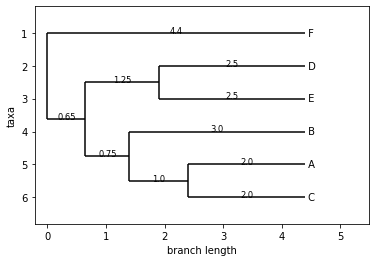

In [77]:
tree = Phylo.read(StringIO(upgma_res), 'newick')
print(tree)
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

In [78]:
wpgma_res = WPGMA(tests[test])

Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.5)
            Clade(branch_length=1.0)
                Clade(branch_length=1.0)
                    Clade(branch_length=2.0, name='A')
                    Clade(branch_length=2.0, name='C')
                Clade(branch_length=3.0, name='B')
            Clade(branch_length=1.5)
                Clade(branch_length=2.5, name='D')
                Clade(branch_length=2.5, name='E')
        Clade(branch_length=4.5, name='F')


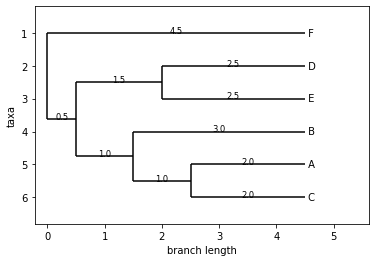

In [79]:
tree = Phylo.read(StringIO(wpgma_res), 'newick')
print(tree)
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

In [83]:
NJ(tests[test])

'(E:2.00,(D:3.00,(F:5.00,(C:2.00,(A:1.00,B:4.00):1.00):1.00):1.00):2.00);'

In [82]:
NJ(test7)

'(8:6.00,(7:2.00,((6:4.00,5:1.00):2.00,(4:3.00,(3:1.00,(2:2.00,1:5.00):2.00):1.00):2.00):1.00):6.00);'